In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

import qiskit
from qiskit import IBMQ, pulse, QuantumCircuit, execute, transpile, Aer, assemble
from qiskit.pulse import library, Schedule, Play, ShiftPhase, DriveChannel
from qiskit.pulse.macros import measure

import qiskit.ignis.verification.randomized_benchmarking as rb

In [2]:
# load IBMQ account and armonk backend
IBMQ.load_account()
armonk_real = IBMQ.providers()[0].backends.ibmq_armonk
# depcopy the inst_map of backend
origin_inst_map = deepcopy(armonk_real.defaults().instruction_schedule_map)

/home/baisiang/miniconda3/envs/Qiskitenv/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [4]:
# import function to modify int_map in the given backend

from functions.backend_modification  import mod_inst_map

In [6]:
# test the function
new_inst_map = mod_inst_map(origin_inst_map, 3, [0])
armonk_real.defaults().instruction_schedule_map = new_inst_map

Original Parameters
{'duration': 640, 'amp': (0.6520131433706463+0j), 'sigma': 160, 'beta': -4.673452668589311}
{'duration': 640, 'amp': (0.3164134858326646-0.010918616694945305j), 'sigma': 160, 'beta': -4.673823483923585}
Modified Parameters
{'duration': 1920, 'amp': (0.2173377144568821+0j), 'sigma': 480, 'beta': -4.673452668589311}
{'duration': 1920, 'amp': (0.10547116194422153-0.003639538898315102j), 'sigma': 480, 'beta': -4.673823483923585}


In [7]:
# Randomized Benchmarking

# set parameters
#Number of qubits
nQ = 1

#Number of seeds (random sequences)
nseeds = 10

#Number of Cliffords in the sequence (start, stop, steps)
# nCliffs = np.arange(1, 200, 10)
nCliffs = [1, 10, 20, 50, 75, 100, 125, 150, 175, 200]

#2Q RB on Q0,Q2 and 1Q RB on Q1
rb_pattern = [[0]]

#Do three times as any 1Q Cliffords
length_multiplier = 1

rb_opts = {'length_vector': nCliffs,
           'nseeds': nseeds,
           'rb_pattern': rb_pattern,
           'group_gates': 'Clifford'}

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)


In [9]:
# import function for measurement error mitigation
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

In [10]:
# mitigate measurement error
# this should be calibrated everyday
initial_layout = [0]
qr = qiskit.QuantumRegister(1)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
job = qiskit.execute(meas_calibs, backend = armonk_real, shots=8192, initial_layout=initial_layout)
cal_results = job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.95910645 0.0760498 ]
 [0.04089355 0.9239502 ]]


In [11]:
# Get the filter object
meas_filter = meas_fitter.filter

In [ ]:
c_list = [1, 3, 5]
shots = 2048
transpiled_circs_list = []
ydata = []
Fitter_list = []
for ci in c_list:
    print('Cj = ', ci)

    # Apply the stretch factor into backend (modify inst_map of the backend)
    temp_inst_map = mod_inst_map(origin_inst_map, ci, [0])
    armonk_real.defaults().instruction_schedule_map = temp_inst_map

    transpiled_circs_list = []
    ydata_temp = []
    rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])

    for rb_seed, rb_circ_seed in enumerate(rb_circs):
        print('Compiling seed %d'%rb_seed)

        # transpile circuit into the basis gate set of the backend
        transpiled_rb_circ_seed = qiskit.transpile(rb_circ_seed,
                                                   armonk_real,
                                                   initial_layout=[0])
        # store the transpiled circuits if need
        for i in range(nseeds):
            transpiled_circs_list.append(transpiled_rb_circ_seed[i])

        print('Simulating seed %d'%rb_seed)

        # translate circuits into pulse through the inst_map in the backend
        # (we have already modify the inst_map of the backend)
        # rb_sceldule = qiskit.schedule(transpiled_rb_circ_seed,
        #                               armonk_real,
        #                               meas_map=armonk_real.configuration().meas_map,
        #                               inst_map=armonk_real.defaults().instruction_schedule_map)
        #
        # # combine the pulse schedules as an assemble
        # rb_qobj = assemble(rb_sceldule,
        #                    backend=armonk_real,
        #                    meas_level=2,
        #                    meas_return='avg',
        #                    shots=shots)

        # implement the assemble on backend
        # real_job = armonk_real.run(rb_qobj)
        real_job = qiskit.execute(transpiled_rb_circ_seed, armonk_real, shots=shots)

        # get the result of job
        rb_result = real_job.result()

        # apply measurement error mitigation to the result
        # rb_mem_result = meas_filter.apply(rb_result)

        # Add mitigated data to the RB fitter
        rb_fit.add_data(rb_result)

        print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))
        ydata_temp.append(rb_fit.ydata[0]['mean'])

    # plot data for each stretch factor c
    plt.figure(figsize=(8, 6), facecolor='w')
    ax = plt.subplot(1, 1, 1)
    # Plot the essence by calling plot_rb_data
    rb_fit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    # Add title and label
    ax.set_title('%d Qubit RB (Cj = %.2f)'%(nQ, ci), fontsize=18)
    plt.show()

    # add data to the list
    ydata.append(ydata_temp)
    Fitter_list.append(rb_fit)

print('Finished running RB')

Cj =  1
Original Parameters
{'duration': 640, 'amp': (0.6520131433706463+0j), 'sigma': 160, 'beta': -4.673452668589311}
{'duration': 640, 'amp': (0.3164134858326646-0.010918616694945305j), 'sigma': 160, 'beta': -4.673823483923585}
Modified Parameters
{'duration': 640, 'amp': (0.6520131433706463+0j), 'sigma': 160, 'beta': -4.673452668589311}
{'duration': 640, 'amp': (0.3164134858326646-0.010918616694945305j), 'sigma': 160, 'beta': -4.673823483923585}
Compiling seed 0
Simulating seed 0
After seed 0, alpha: 0.998882, EPC: 0.000559
Compiling seed 1
Simulating seed 1
After seed 1, alpha: 0.998868, EPC: 0.000566
Compiling seed 2
Simulating seed 2
After seed 2, alpha: 0.999069, EPC: 0.000466
Compiling seed 3
Simulating seed 3
After seed 3, alpha: 0.999225, EPC: 0.000388
Compiling seed 4
Simulating seed 4
After seed 4, alpha: 0.999311, EPC: 0.000345
Compiling seed 5
Simulating seed 5
After seed 5, alpha: 0.999332, EPC: 0.000334
Compiling seed 6
Simulating seed 6
After seed 6, alpha: 0.999338, 

In [26]:
# Calculate the gamma constant for Richardson Extrapolation
print('c = ', c_list)

def gamma_j(c_list_):
    gamma_list = []
    for j in range(len(c_list_)):
        gamma_temp = 1
        for m_a in range(j):
            gamma_temp *= c_list_[m_a]/(c_list_[j]-c_list_[m_a])
        for m_b in range(len(c_list_)-j-1):
            gamma_temp *= c_list_[m_b+j+1]/(c_list_[j]-c_list_[m_b+j+1])
        gamma_list.append(gamma_temp)
    # if len(c_list_)%2==0:
        # gamma_list *= (-1)
    return gamma_list
gamma_list = gamma_j(c_list)
print('gamma = ', gamma_list)

# Check the constant didn't obey the constraint
# (Summation of gamma_j = 1)
# (Summation of gamma_j * c_j**k (k from 1 to n) = 0)
print('check constraints')
print('j from 0 to n = ', len(c_list)-1)
print('Summation of gamma_j = ',sum(gamma_list))
rc = 0
for k in range(len(c_list)-1):
    for i in range(len(gamma_list)):
        rc += c_list[i]**(k+1)*gamma_list[i]
print('Summation of gamma_j * c_j**(from 1 to n) = ', rc)

c =  [1, 5, 10]
gamma =  [1.3888888888888888, -0.5, 0.1111111111111111]
check constraints
j from 0 to n =  2
Summation of gamma_j =  1.0
Summation of gamma_j * c_j**(from 1 to n) =  0.0


In [27]:
# calculate extrapolation result
ext_data = np.zeros(len(ydata[0][-1]))
for i in range(len(ext_data)):
    ext_temp = 0
    for j in range(len(c_list)):
        ext_temp += gamma_list[j]*ydata[j][-1][i]
    ext_data[i] = ext_temp
# print(ext_data)

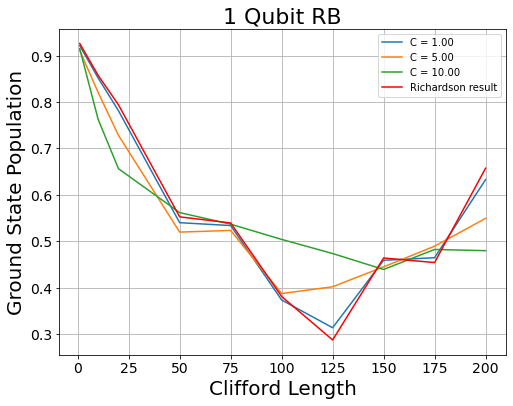

In [28]:
plt.figure(figsize=(8, 6), facecolor='w')
plt.title('%d Qubit RB'%(nQ), fontsize=22)
plt.xlabel('Clifford Length', fontsize=20)
plt.ylabel('Ground State Population', fontsize=20)
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.grid()
for i in range(len(c_list)):
    plt.plot(xdata[0], ydata[i][-1], label='C = %.2f'%c_list[i])

plt.plot(xdata[0], ext_data, 'r', label = 'Richardson result')
plt.legend()
# plt.savefig('Richardson_RB_result.jpg', dpi=150)

plt.show()

In [24]:
rb_fit.rb_fit_fun()

TypeError: _rb_fit_fun() missing 4 required positional arguments: 'x', 'a', 'alpha', and 'b'